<h1>CADRL Complete Training (IL + RL)</h1>

Import the necessary packages

In [15]:
from jax import random, device_get
import jax.numpy as jnp
import optax
import numpy as np
import time
import matplotlib.pyplot as plt

from socialjym.envs.socialnav import SocialNav
from socialjym.policies.cadrl import CADRL
from socialjym.utils.replay_buffers.uniform_vnet_replay_buffer import UniformVNetReplayBuffer
from socialjym.utils.rollouts.deep_vnet_rollouts import deep_vnet_rl_rollout, deep_vnet_il_rollout
from socialjym.utils.aux_functions import epsilon_scaling_decay, plot_state, plot_trajectory, test_k_trials
from socialjym.utils.rewards.reward1 import generate_reward_done_function

Set the training hyperparameters

In [16]:
random_seed = 1
il_training_episodes = 3_000
il_learning_rate = 0.01
il_num_epochs = 50 # Number of epochs to train the model after ending IL
rl_training_episodes = 10_000
rl_learning_rate = 0.001
rl_num_batches = 100 # Number of batches to train the model after each RL episode
batch_size = 100 # Number of experiences to sample from the replay buffer for each model update
epsilon_start = 0.5
epsilon_end = 0.1
epsilon_decay = 4_000
buffer_size = 100_000 # Maximum number of experiences to store in the replay buffer (after exceeding this limit, the oldest experiences are overwritten with new ones)
target_update_interval = 50 # Number of episodes to wait before updating the target network for RL (the one used to compute the target state values)
humans_policy = 'sfm'

Set the reward and environment parameters

In [17]:
# Reward function parameters
reward_params = {
    'goal_reward': 1.,
    'collision_penalty': 0.25,
    'discomfort_distance': 0.2,
    'time_limit': 50.,
}

# Initialize reward function
reward_function = generate_reward_done_function(**reward_params)

# Environment parameters
env_params = {
    'robot_radius': 0.3,
    'n_humans': 1,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': False,
    'scenario': 'circular_crossing',
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}

Initialize environment, robot policy and replay buffer

In [18]:
# Initialize environment
env = SocialNav(**env_params)

# Initialize robot policy and vnet params
policy = CADRL(env.reward_function, dt=env_params['robot_dt'])
initial_vnet_params = policy.model.init(random.key(random_seed), jnp.zeros((policy.vnet_input_size,)))

# Initialize replay buffer
replay_buffer = UniformVNetReplayBuffer(buffer_size, batch_size)

<h2>Imitation Learning</h2>

Initialize the optimizer and the buffer state dictionary (where experiences will be stored)

In [19]:
# Initialize IL optimizer
optimizer = optax.sgd(learning_rate=il_learning_rate, momentum=0.9)

# Initialize buffer state
buffer_state = {
    'vnet_inputs': jnp.empty((buffer_size, env.n_humans, policy.vnet_input_size)),
    'targets': jnp.empty((buffer_size,1)),
}

Set all the parameters for the imitation learning rollout

In [20]:
il_rollout_params = {
    'initial_vnet_params': initial_vnet_params,
    'train_episodes': il_training_episodes,
    'random_seed': random_seed,
    'optimizer': optimizer,
    'buffer_state': buffer_state,
    'current_buffer_size': 0,
    'policy': policy,
    'env': env,
    'replay_buffer': replay_buffer,
    'buffer_size': buffer_size,
    'num_epochs': il_num_epochs,
    'batch_size': batch_size,
    'success_reward': reward_params['goal_reward'],
    'failure_reward': reward_params['collision_penalty']
}

During imitation learning, the robot will move using the same policy used by humans. Let's start the rollout.

In [21]:
il_out = deep_vnet_il_rollout(**il_rollout_params)

Simulating IL episodes...


Running for 3,000 iterations: 100%|██████████| 3000/3000 [00:02<00:00, 1330.39it/s]


Buffer size after IL: 100000
Optimizing model on generated experiences for 50 epochs...


Running for 50 iterations: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


Now, we save the parameters we are interested in from the rollout output and we plot the discounted return over the IL training episodes and the loss over the optimization epochs.

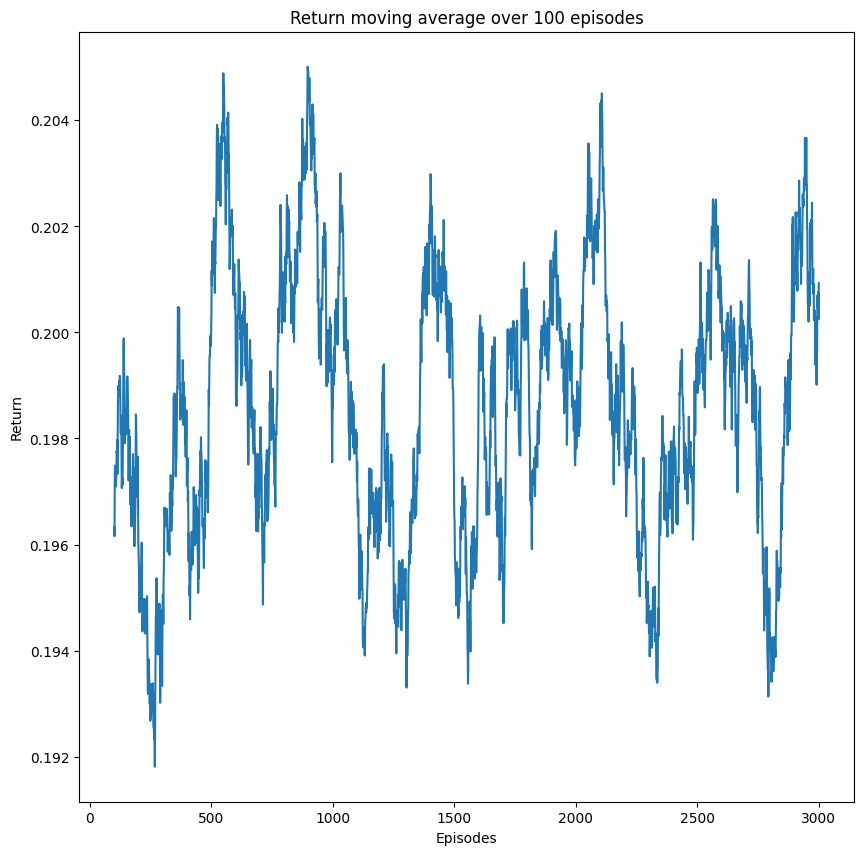

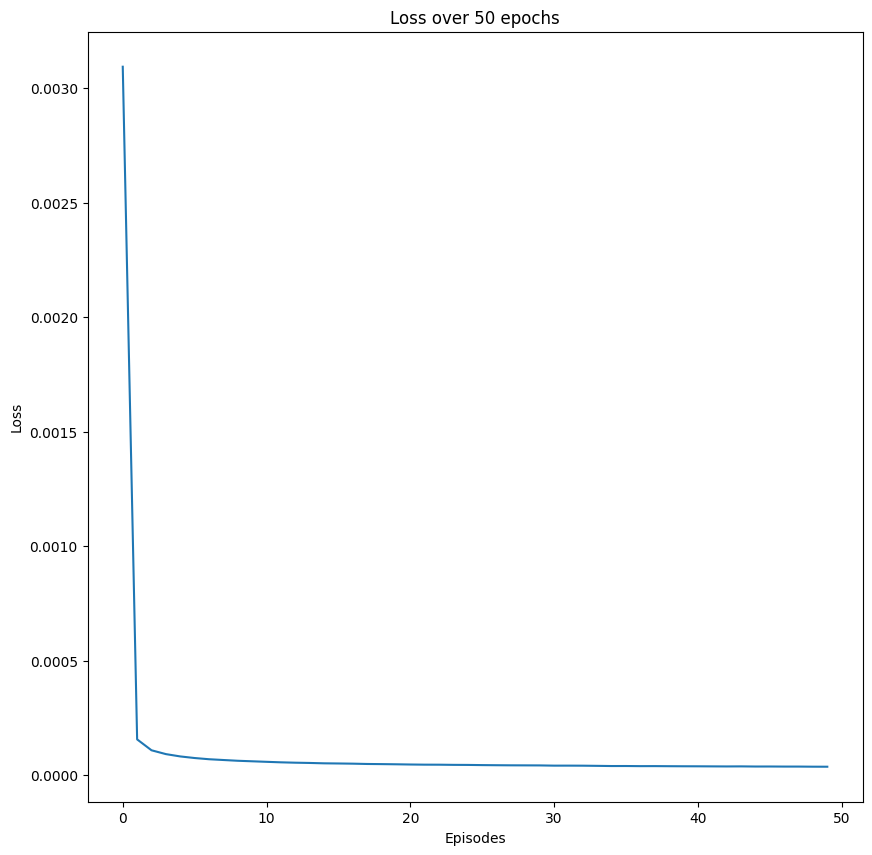

In [22]:
# Save the IL model parameters, buffer state, and keys
il_model_params = il_out['model_params']
reset_key = il_out['reset_key']
policy_key = il_out['policy_key']
buffer_state = il_out['buffer_state']
current_buffer_size = il_out['current_buffer_size']

# Plot the losses and returns
window = 100
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Return', title='Return moving average over {} episodes'.format(window))
ax.plot(np.arange(len(il_out['returns'])-(window-1))+window, jnp.convolve(il_out['returns'], jnp.ones(window,), 'valid') / window)
plt.show()
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Loss', title='Loss over {} epochs'.format(len(il_out['losses'])))
ax.plot(np.arange(len(il_out['losses'])), il_out['losses'])
plt.show()

Let's test the IL trained agent on 1000 unseen trials. The robot is still NOT visible by humans here.

In [23]:
test_k_trials(1000, 2, env, policy, il_model_params)

Executing 1000 tests with 1 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:11<00:00, 90.87it/s]


RESULTS
Success rate: 1.00
Collision rate: 0.00
Timeout rate: 0.00
Average return: 0.07
Average time to goal: 27.26


{'collisions': Array(0, dtype=int32, weak_type=True),
 'returns': Array([0.04352255, 0.02252838, 0.14619267, 0.03815201, 0.14619267,
        0.15821357, 0.0371602 , 0.14619267, 0.1541006 , 0.12482148,
        0.1350851 , 0.02503153, 0.03257476, 0.15821357, 0.03433681,
        0.15821357, 0.14619267, 0.0243808 , 0.0243808 , 0.02503153,
        0.02708978, 0.03619418, 0.0213723 , 0.15821357, 0.08408116,
        0.02781281, 0.12815298, 0.02312966, 0.0371602 , 0.03257476,
        0.04964908, 0.12815298, 0.14619267, 0.13869055, 0.04021575,
        0.0371602 , 0.1541006 , 0.1624363 , 0.0243808 , 0.10941893,
        0.12482148, 0.02708978, 0.03344418, 0.03433681, 0.13869055,
        0.02638555, 0.09099485, 0.04021575, 0.12482148, 0.14619267,
        0.02312966, 0.03090313, 0.02194273, 0.0371602 , 0.1541006 ,
        0.04964908, 0.0371602 , 0.02638555, 0.04468417, 0.02194273,
        0.14619267, 0.12815298, 0.03619418, 0.04239113, 0.05233473,
        0.05097422, 0.02503153, 0.03815201, 0.03172

<h2>Reinforcement Learning</h2>

Initialize the optimizer and the next rollout parameters. We should start from the model parameters compute after IL.

In [24]:
# Initialize RL optimizer
optimizer = optax.sgd(learning_rate=rl_learning_rate, momentum=0.9)

# Initialize RL rollout params
rl_rollout_params = {
    'initial_vnet_params': il_model_params,
    'train_episodes': rl_training_episodes,
    'random_seed': random_seed,
    'model': policy.model,
    'optimizer': optimizer,
    'buffer_state': buffer_state,
    'current_buffer_size': current_buffer_size,
    'policy': policy,
    'env': env,
    'replay_buffer': replay_buffer,
    'buffer_size': buffer_size,
    'num_batches': rl_num_batches,
    'epsilon_decay_fn': epsilon_scaling_decay,
    'epsilon_start': epsilon_start,
    'epsilon_end': epsilon_end,
    'decay_rate': epsilon_decay,
    'target_update_interval': target_update_interval,
    'success_reward': reward_params['goal_reward'],
    'failure_reward': reward_params['collision_penalty']
}

Let's start the RL rollout.

In [25]:
rl_out = deep_vnet_rl_rollout(**rl_rollout_params)

Running for 10,000 iterations: 100%|██████████| 10000/10000 [13:24<00:00, 12.44it/s]


Save the final model parameters and plot discounted return and loss over the RL training episodes.

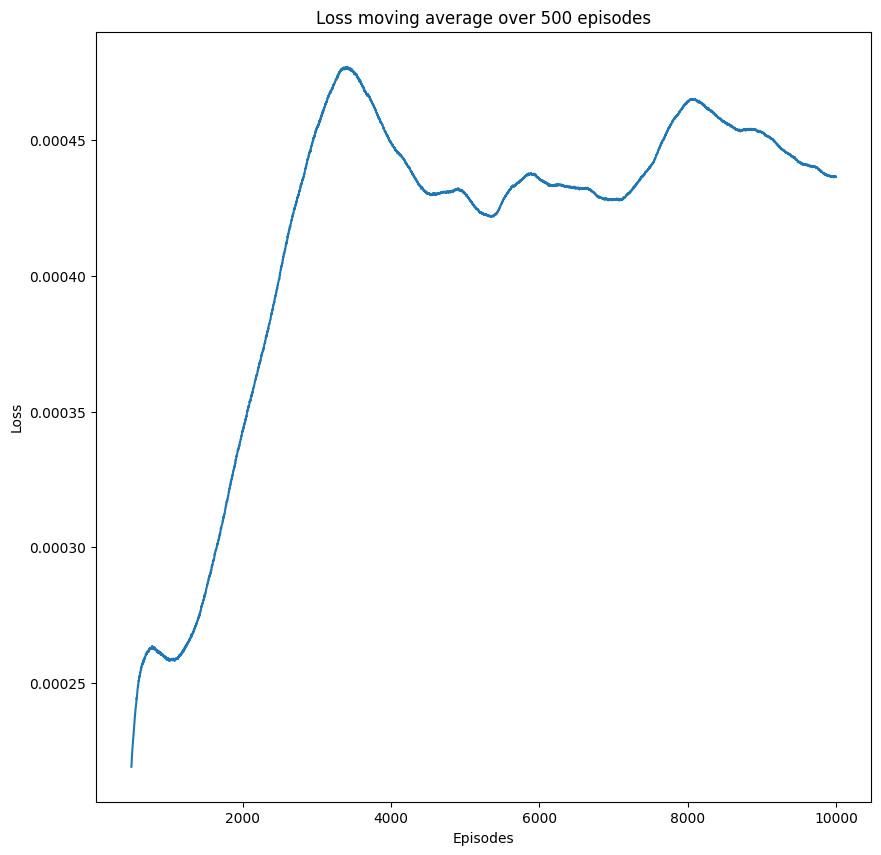

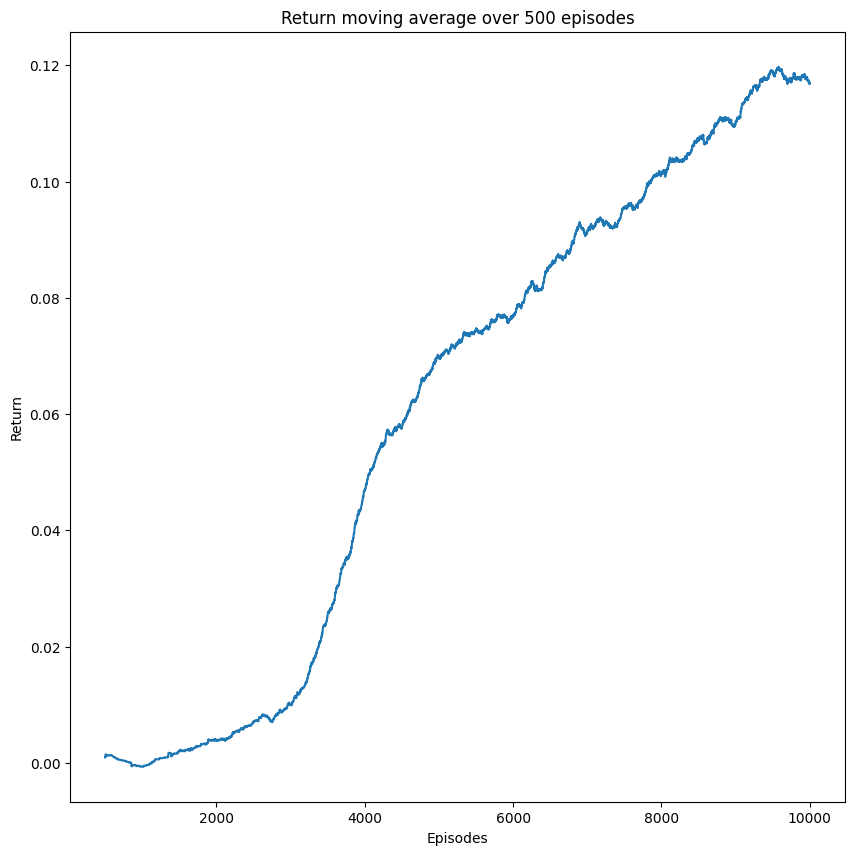

In [26]:
# Save the final model parameters and keys
final_model_params = rl_out['model_params']
reset_key = rl_out['reset_key']
policy_key = rl_out['policy_key']

figure, ax = plt.subplots(figsize=(10,10))
window = 500
ax.plot(np.arange(len(rl_out['losses'])-(window-1))+window, jnp.convolve(rl_out['losses'], jnp.ones(window,), 'valid') / window)
ax.set(xlabel='Episodes', ylabel='Loss', title='Loss moving average over {} episodes'.format(window))
plt.show()
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Return', title='Return moving average over {} episodes'.format(window))
ax.plot(np.arange(len(rl_out['returns'])-(window-1))+window, jnp.convolve(rl_out['returns'], jnp.ones(window,), 'valid') / window)
plt.show()

Let's test the RL trained agent in three environments, with 1, 5 and 10 humans. In all environments the robot is visible.

In [27]:
env_params = {
    'robot_radius': 0.3,
    'n_humans': 1,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': 'circular_crossing',
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}
env = SocialNav(**env_params)
env5_params = {
    'robot_radius': 0.3,
    'n_humans': 5,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': 'circular_crossing',
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}
env5 = SocialNav(**env5_params)
env10_params = {
    'robot_radius': 0.3,
    'n_humans': 10,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': 'circular_crossing',
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}
env10 = SocialNav(**env10_params)
test_k_trials(1000, 3, env, policy, final_model_params)
test_k_trials(1000, 3, env5, policy, final_model_params)
test_k_trials(1000, 3, env10, policy, final_model_params)

Executing 1000 tests with 1 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:09<00:00, 111.08it/s]



RESULTS
Success rate: 1.00
Collision rate: 0.00
Timeout rate: 0.00
Average return: 0.15
Average time to goal: 17.98
Executing 1000 tests with 5 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:43<00:00, 23.23it/s]



RESULTS
Success rate: 0.99
Collision rate: 0.00
Timeout rate: 0.01
Average return: 0.17
Average time to goal: 16.69
Executing 1000 tests with 10 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [01:24<00:00, 11.79it/s]


RESULTS
Success rate: 0.97
Collision rate: 0.00
Timeout rate: 0.03
Average return: 0.18
Average time to goal: 16.09


{'collisions': Array(0, dtype=int32, weak_type=True),
 'returns': Array([0.17671648, 0.1785617 , 0.19024767, 0.14036053, 0.17498207,
        0.14282343, 0.18048479, 0.17542605, 0.1953254 , 0.18530194,
        0.17883413, 0.1795193 , 0.20053865, 0.18530194, 0.1644937 ,
        0.18971534, 0.16534644, 0.12071508, 0.16407955, 0.18466713,
        0.20314792, 0.20886943, 0.18499175, 0.17579286, 0.1541006 ,
        0.17579286, 0.18048479, 0.17097355, 0.20154092, 0.20053865,
        0.18982811, 0.1575136 , 0.18879262, 0.16552742, 0.17084216,
        0.1709721 , 0.1399189 , 0.17561774, 0.18355776, 0.18048479,
        0.17579286, 0.19448997, 0.18053931, 0.18048479, 0.17738327,
        0.18023156, 0.19419147, 0.18530194, 0.14815916, 0.1953254 ,
        0.20053865, 0.19002911, 0.17395572, 0.18488167, 0.15927461,
        0.14431046, 0.17452036, 0.17117752, 0.1954845 , 0.20589104,
        0.18725842, 0.1953254 , 0.20427778, 0.16671678, 0.16657117,
        0.20177509, 0.1953254 , 0.20036341, 0.21138

Simulate some episodes using the trained agent.

Episode 0 ended - Execution time 2.2 seconds - Plotting trajectory...


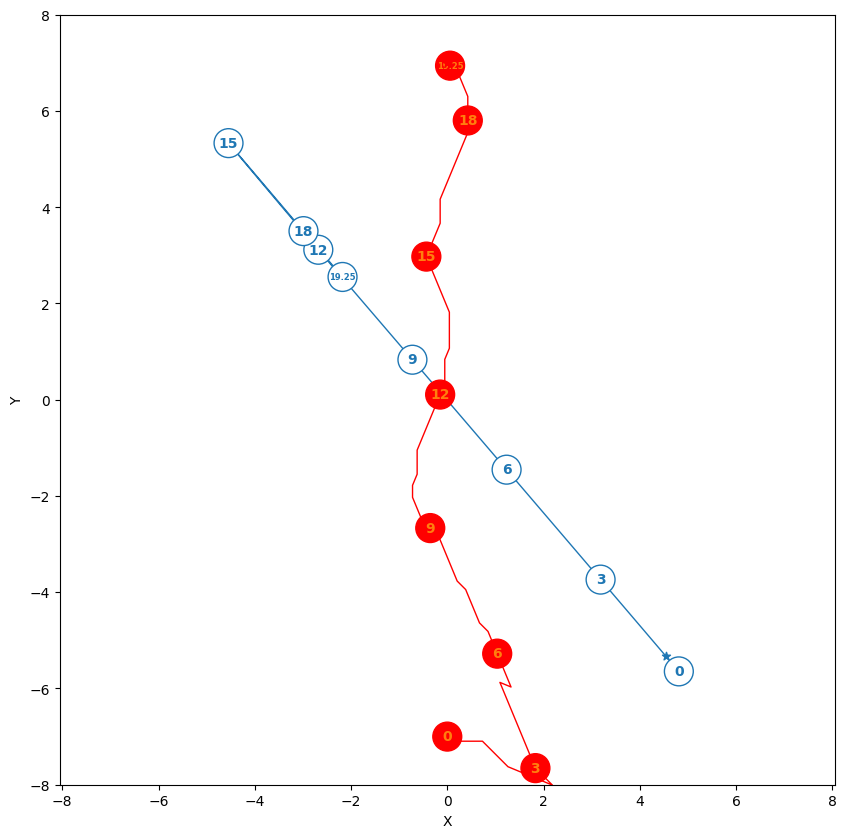

Episode 1 ended - Execution time 0.03 seconds - Plotting trajectory...


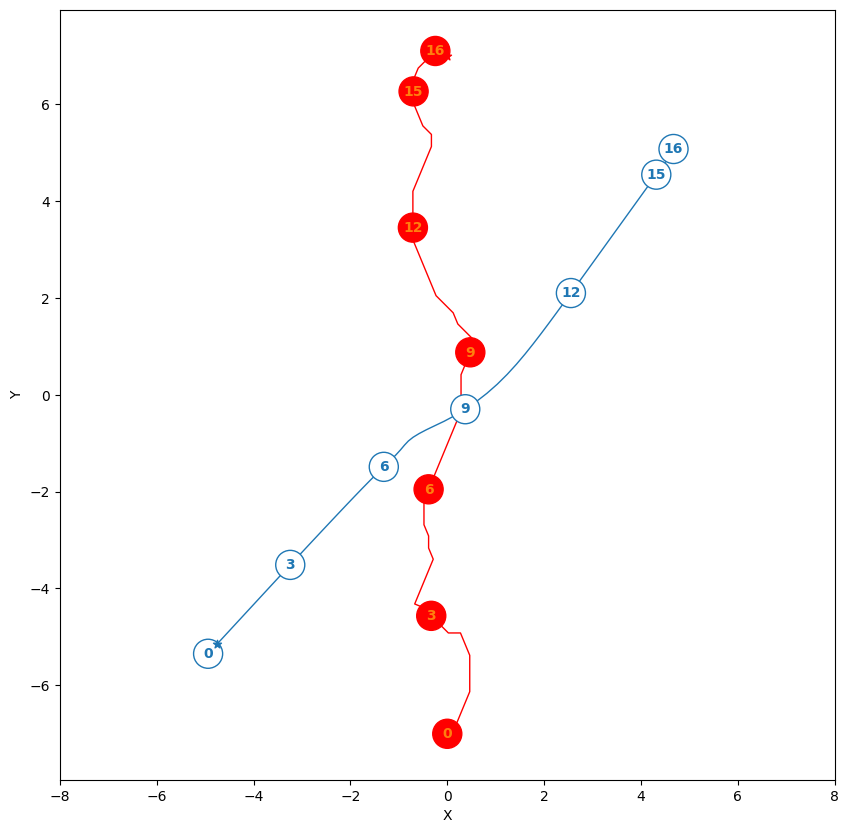

Episode 2 ended - Execution time 0.03 seconds - Plotting trajectory...


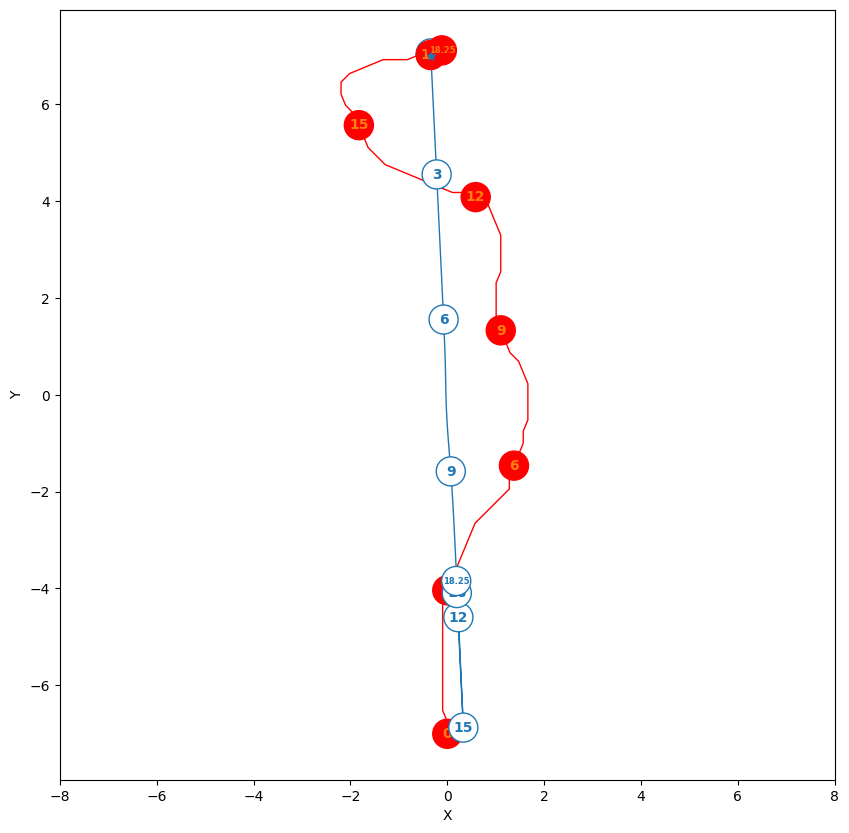

Episode 3 ended - Execution time 0.03 seconds - Plotting trajectory...


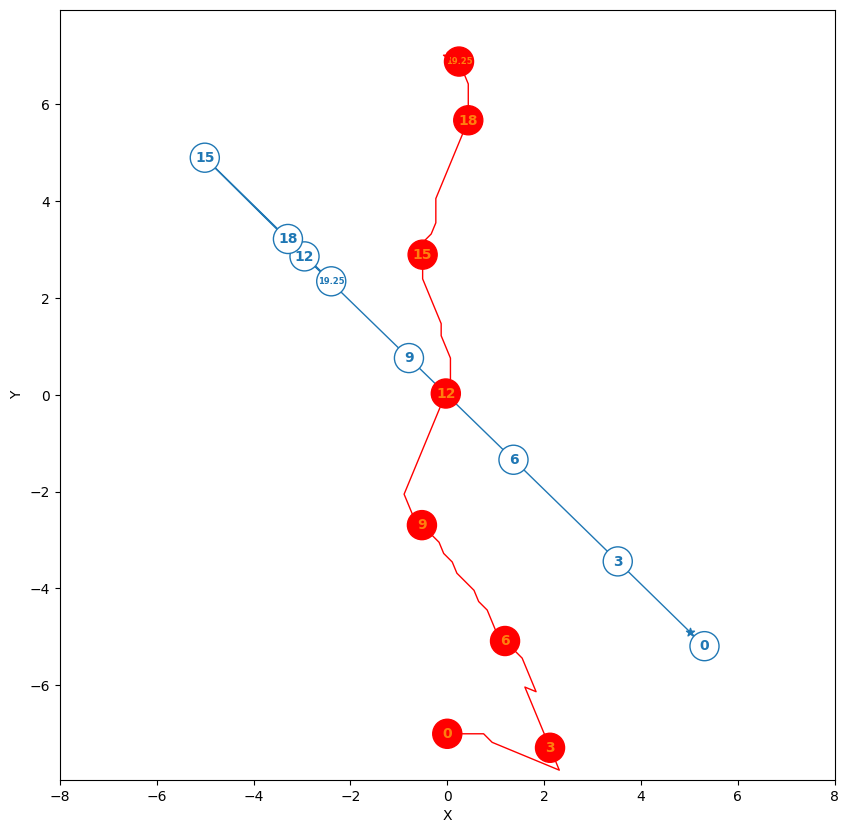

Episode 4 ended - Execution time 0.03 seconds - Plotting trajectory...


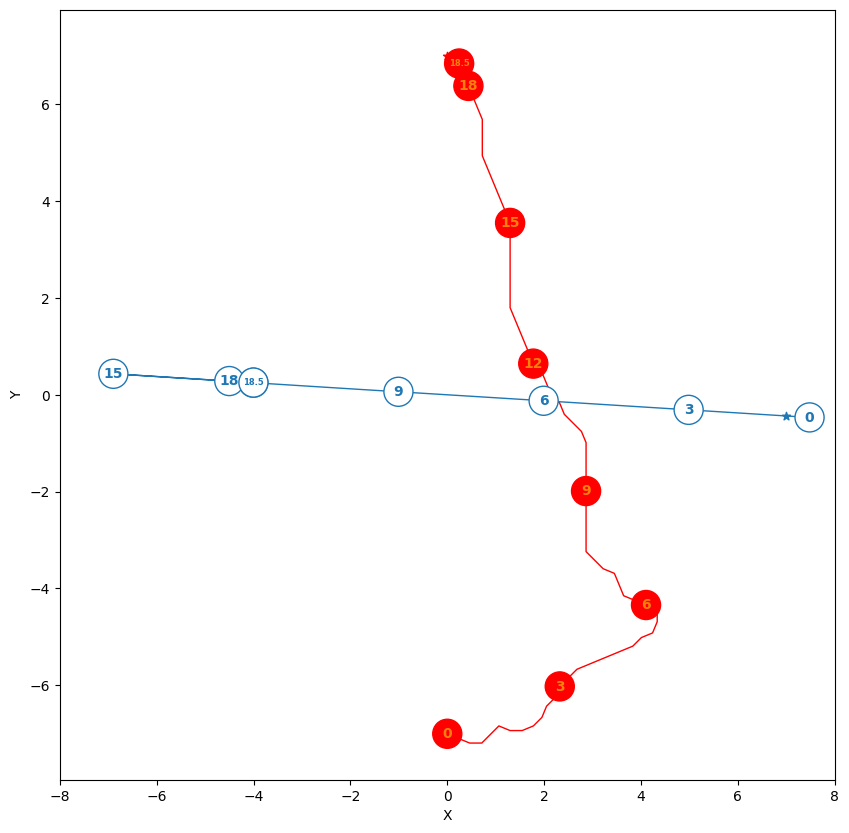

Average time per episode: 0.46 seconds
Total time for 5 episodes: 2.32 seconds


In [28]:
n_episodes = 5
env_params["n_humans"] = 1
env = SocialNav(**env_params)
# Simulate some episodes
episode_simulation_times = np.empty((n_episodes,))
for i in range(n_episodes):
    done = False
    episode_start_time = time.time()
    state, reset_key, obs, info = env.reset(reset_key)
    all_states = np.array([state])
    while not done:
        # action = jnp.array([0.,1.]) # Move north
        action, policy_key, _ = policy.act(policy_key, obs, info, final_model_params, 0.)
        state, obs, info, reward, done = env.step(state,info,action) 
        all_states = np.vstack((all_states, [state]))
    episode_simulation_times[i] = round(time.time() - episode_start_time,2)
    all_states = device_get(all_states) # Transfer data from GPU to CPU for plotting
    print(f"Episode {i} ended - Execution time {episode_simulation_times[i]} seconds - Plotting trajectory...")
    ## Plot episode trajectory
    figure, ax = plt.subplots(figsize=(10,10))
    ax.axis('equal')
    plot_trajectory(ax, all_states, info['humans_goal'], info['robot_goal'])
    for k in range(0,len(all_states),int(3/env_params['robot_dt'])):
        plot_state(ax, k*env_params['robot_dt'], all_states[k], env_params['humans_policy'], env_params['scenario'], info["humans_parameters"][:,0], env.robot_radius)
    # plot last state
    plot_state(ax, (len(all_states)-1)*env_params['robot_dt'], all_states[len(all_states)-1], env_params['humans_policy'], env_params['scenario'], info["humans_parameters"][:,0], env.robot_radius)
    plt.show()
# Print simulation times
print(f"Average time per episode: {round(np.mean(episode_simulation_times),2)} seconds")
print(f"Total time for {n_episodes} episodes: {round(np.sum(episode_simulation_times),2)} seconds")